In [95]:
from typing import List, Dict, Tuple

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----'
}

linestyle = {
    'Vector': '-',
    'Skiplist': '--',
    'Hashskiplist': '-.',
    'Hashlinklist': ':'
}

alpha = {
    'Vector': 1,
    'Skiplist': 0.6,
    'Hashskiplist': 1,
    'Hashlinklist': 0.8
}

color = {
    # 'Vector': 'darkslateblue',
    # 'Skiplist': 'olive',
    # 'Hashskiplist': 'darkred',
    # 'Hashlinklist': 'steelblue'
    # 'Vector': 'black',
    # 'Skiplist': 'black',
    # 'Hashskiplist': 'black',
    # 'Hashlinklist': 'black'
}

edgecolor = {
    'Vector': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

label = {
    'Vector': 'vector',
    'Skiplist': 'skiplist',
    'Hashskiplist': 'hash skiplist',
    'Hashlinklist': 'hash linklist'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

def get_properties(key: str) -> Dict[str, str]:
    if key.capitalize() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": color.get(key.capitalize()) or "None",
            "edgecolor": edgecolor.get(key.capitalize()) or "None",
            # "linestyle": linestyle.get(key.capitalize()),
            "hatch": hatch.get(key.capitalize()),
            "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")


In [96]:
def get_exp_dirname(query_type: str, selectivity: float, entry_size: int, epp: int) -> str:
    return (
        f"{__WORKING_BRANCH_PATH}/experiments-{query_type}-{selectivity}-{entry_size}-{epp}"
    )


def get_log_dirname(
    query_type: str,
    inserts: int,
    point_queries: int,
    range_queries: int,
    selectivity: float,
    memtable: str,
    entry_size: int,
    number_of_entries_per_page: int,
    number_of_pages: int,
    prefixlen: int = 0,
    bucket_count: int = 0,
    size_ratio: int = 4,
    updates: int = 0,
):
    if memtable.lower() in ("hashskiplist", "hashlinklist"):
        return f"{get_exp_dirname(query_type, selectivity, entry_size, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio} l {prefixlen} bucket_count {bucket_count}"
    return f"{get_exp_dirname(query_type, selectivity, entry_size, number_of_entries_per_page)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio}"

In [97]:
def process_log_file(
    log_file: str, logs_dict: dict, index, key: str = "", key_to_search: str = ""
):
    with open(log_file + "/workload.log", "r") as ff:
        for line in ff.readlines():
            if line.startswith(key_to_search):
                temp_line = line.strip(key_to_search)
                logs_dict[key] = int(temp_line.split(" ")[index])
                break

def process_flush_stats(log_dir: str, logs_dict: dict):
    filepath = f"{log_dir}/flush_stats.csv"

    df = pd.read_csv(filepath)
    logs_dict["TotalFlushes"] = df.shape[0] - 1
    logs_dict["entriesLeft"] = df.iloc[-1]["NumEntries"]
    logs_dict["AverageFlushSizeBytes"] = df.iloc[:-1]["DataSize"].mean()
    logs_dict["AvgNumberofFlushEntries"] = df.iloc[:-1]["NumEntries"].mean()

def autolabel(rectangle_group, ax, value):
    for rect in rectangle_group[1:]:
        height = rect.get_height()
        ax.annotate(f"{value/1000:.2f}K$^+$",
                xy = (rect.get_x() + rect.get_width() / 2, height),
                ha='center', color = 'black', rotation=90, xytext=(0,5), textcoords="offset points")


In [98]:
query_type = "Footprint-And-Writes"
entry_size = 64
memtables = ["Vector", "SkipList", "Hashskiplist", "Hashlinklist"]
inserts = 1500000
point_queries = 0
range_queries = 0
number_of_entries_per_page = 64
number_of_pages = 4096
updates = 0
prefixlen = 4
bucket_count = 100000

selectivities = [0]
list_memdf1 = []
list_memdf2 = []
titles = []

for selectivity in selectivities:
    vec_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[0],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    skip_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[1],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    hash_skip_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[2],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    hash_link_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[3],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )


    vec_stats = dict()
    skip_stats = dict()
    hash_skip_stats = dict()
    hash_link_stats = dict()

    process_log_file(vec_logdir, vec_stats, 0, "CompactReads", "rocksdb.compact.read.bytes COUNT : ")
    process_log_file(vec_logdir, vec_stats, 0, "CompactWrites", "rocksdb.compact.write.bytes COUNT : ")
    process_log_file(vec_logdir, vec_stats, 0, "FlushWrites", "rocksdb.flush.write.bytes COUNT : ")
    process_log_file(vec_logdir, vec_stats, 14, "NumCompactions", "rocksdb.compaction.times.micros ")
    process_flush_stats(vec_logdir, vec_stats)

    process_log_file(skip_logdir, skip_stats, 0, "CompactReads", "rocksdb.compact.read.bytes COUNT : ")
    process_log_file(skip_logdir, skip_stats, 0, "CompactWrites", "rocksdb.compact.write.bytes COUNT : ")
    process_log_file(skip_logdir, skip_stats, 0, "FlushWrites", "rocksdb.flush.write.bytes COUNT : ")
    process_log_file(skip_logdir, skip_stats, 14, "NumCompactions", "rocksdb.compaction.times.micros ")
    process_flush_stats(skip_logdir, skip_stats)


    process_log_file(hash_skip_logdir, hash_skip_stats, 0, "CompactReads", "rocksdb.compact.read.bytes COUNT : ")
    process_log_file(hash_skip_logdir, hash_skip_stats, 0, "CompactWrites", "rocksdb.compact.write.bytes COUNT : ")
    process_log_file(hash_skip_logdir, hash_skip_stats, 0, "FlushWrites", "rocksdb.flush.write.bytes COUNT : ")
    process_log_file(hash_skip_logdir, hash_skip_stats, 14, "NumCompactions", "rocksdb.compaction.times.micros ")
    process_flush_stats(hash_skip_logdir, hash_skip_stats)

    process_log_file(hash_link_logdir, hash_link_stats, 0, "CompactReads", "rocksdb.compact.read.bytes COUNT : ")
    process_log_file(hash_link_logdir, hash_link_stats, 0, "CompactWrites", "rocksdb.compact.write.bytes COUNT : ")
    process_log_file(hash_link_logdir, hash_link_stats, 0, "FlushWrites", "rocksdb.flush.write.bytes COUNT : ")
    process_log_file(hash_link_logdir, hash_link_stats, 14, "NumCompactions", "rocksdb.compaction.times.micros ")
    process_flush_stats(hash_link_logdir, hash_link_stats)

    vecdf = pd.DataFrame(vec_stats, index=[0])
    skipdf = pd.DataFrame(skip_stats, index=[0])
    hash_skipdf = pd.DataFrame(hash_skip_stats, index=[0])
    hash_linkdf = pd.DataFrame(hash_link_stats, index=[0])


/tmp/ipykernel_289037/2199964805.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f"{int(i/(1000*1000))}" for i in ax[0].get_yticks()], fontsize=12)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


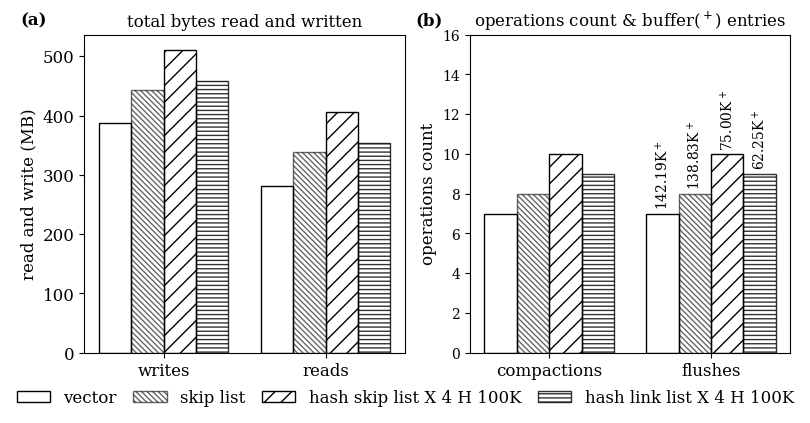

In [99]:

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

width = 0.2
vec_x = [1-0.3, 2-0.3]
skip_x = [1-0.1, 2-0.1]
hash_skipdf_x = [1+0.1, 2+0.1]
hash_linkdf_x = [1+0.3, 2+0.3]

bar1 = ax[0].bar(
    vec_x,
    [vecdf["CompactWrites"].values[0] + vecdf["FlushWrites"].values[0], vecdf["CompactReads"].values[0]],
    width,
    label = "vector",
    **get_properties("Vector"),
)
    
bar2 = ax[0].bar(
    skip_x,
    [skipdf["CompactWrites"].values[0] + skipdf["FlushWrites"].values[0], skipdf["CompactReads"].values[0]],
    width,
    label = "skip list",
    **get_properties("Skiplist"),
)

bar3 = ax[0].bar(
    hash_skipdf_x,
    [hash_skipdf["CompactWrites"].values[0] + hash_skipdf["FlushWrites"].values[0], hash_skipdf["CompactReads"].values[0]],
    width,
    label=f"hash skip list X {prefixlen} H {bucket_count//1000}K",
    **get_properties("Hashskiplist"),
)

bar4 = ax[0].bar(
    hash_linkdf_x,
    [hash_linkdf["CompactWrites"].values[0] + hash_linkdf["FlushWrites"].values[0], hash_linkdf["CompactReads"].values[0]],
    width,
    label=f"hash link list X {prefixlen} H {bucket_count//1000}K",
    **get_properties("Hashlinklist"),
)
    
x_ticks = [1, 2]
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(["writes", "reads"], fontsize=12)

ax[0].set_title(f"total bytes read and written", fontsize=12)
ax[0].set_ylabel("read and write (MB)", fontsize=12)

ax[0].text(x=-0.20, y=1.03, s='(a)', fontsize=12,
    horizontalalignment='left', 
    transform=ax[0].transAxes, fontweight='bold')

ax[0].set_yticklabels([f"{int(i/(1000*1000))}" for i in ax[0].get_yticks()], fontsize=12)

# ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize=12)


bar5 = ax[1].bar(
    vec_x,
    [vecdf["NumCompactions"].values[0], vecdf["TotalFlushes"].values[0]],
    width,
    label="vector",
    **get_properties("Vector"),
)

bar6 = ax[1].bar(
    skip_x,
    [skipdf["NumCompactions"].values[0], skipdf["TotalFlushes"].values[0]],
    width,
    label="skip list",
    **get_properties("skiplist"),
)

bar7 = ax[1].bar(
    hash_skipdf_x,
    [hash_skipdf["NumCompactions"].values[0], hash_skipdf["TotalFlushes"].values[0]],
    width,
    label=f"hash skip list X {prefixlen} H {bucket_count//1000}K",
    **get_properties("Hashskiplist"),
)

bar8 = ax[1].bar(
    hash_linkdf_x,
    [hash_linkdf["NumCompactions"].values[0], hash_linkdf["TotalFlushes"].values[0]],
    width,
    label=f"hash link list X {prefixlen} H {bucket_count//1000}K",
    **get_properties("Hashlinklist"),
)

autolabel(bar5, ax[1], vecdf["entriesLeft"].values[0])
autolabel(bar6, ax[1], skipdf["entriesLeft"].values[0])
autolabel(bar7, ax[1], hash_skipdf["entriesLeft"].values[0])
autolabel(bar8, ax[1], hash_linkdf["entriesLeft"].values[0])


ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(["compactions", "flushes"], fontsize=12)
ax[1].set_title(f"operations count & buffer($^+$) entries", fontsize=12)
ax[1].set_ylabel("operations count", fontsize=12)
ax[1].set_ylim(bottom=0, top=16)
# ax[1].legend(loc="upper right", fontsize=12)
ax[1].text(x=-0.17, y=1.03, s='(b)', fontsize=12,
    horizontalalignment='left', 
    transform=ax[1].transAxes, fontweight='bold')

fig.legend(handles=[bar1, bar2, bar3, bar4], loc='upper center', ncol=4, fontsize=12, bbox_to_anchor=(0.5, 0.05), frameon=False, columnspacing=1)

plt.tight_layout() 
plt.savefig("flush-compaction.eps", format="eps", bbox_inches="tight", dpi=1200)
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [100]:
marker = {
    'Vector': 'o',
    'Skiplist': 's',
    'Hashskiplist': 'd',
    'Hashlinklist': '^'
}

def get_properties(key: str) -> Dict[str, str]:
    if key.capitalize() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": "black",
            # "edgecolor": edgecolor.get(key.capitalize()) or "None",
            "linestyle": linestyle.get(key.capitalize()),
            "marker": marker.get(key.capitalize()),
            # "hatch": hatch.get(key.capitalize()),
            # "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")

In [101]:

prefixlens = [2, 4, 8, 10]
bucket_count = [1000, 10000, 50000, 100000, 1000000]

vec_logdir = get_log_dirname(
    query_type,
    inserts,
    point_queries,
    range_queries,
    selectivity,
    memtables[0],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen,
    bucket_count,
)

skip_logdir = get_log_dirname(
    query_type,
    inserts,
    point_queries,
    range_queries,
    selectivity,
    memtables[1],
    entry_size,
    number_of_entries_per_page,
    number_of_pages,
    prefixlen,
    bucket_count,
)

vec_stats = dict()
skip_stats = dict()

process_flush_stats(vec_logdir, vec_stats)
process_flush_stats(skip_logdir, skip_stats)

hash_skip_stats = list()
hash_link_stats = list()

for prefixlen in prefixlens:
    for bucket in bucket_count:
        temp_dict = {
            "prefixlen": prefixlen,
            "bucket_count": bucket
        }

        hash_skip_logdir = get_log_dirname(
            query_type,
            inserts,
            point_queries,
            range_queries,
            selectivity,
            memtables[2],
            entry_size,
            number_of_entries_per_page,
            number_of_pages,
            prefixlen,
            bucket,
        )

        hash_link_logdir = get_log_dirname(
            query_type,
            inserts,
            point_queries,
            range_queries,
            selectivity,
            memtables[3],
            entry_size,
            number_of_entries_per_page,
            number_of_pages,
            prefixlen,
            bucket,
        )

        process_flush_stats(hash_skip_logdir, temp_dict)
        hash_skip_stats.append(temp_dict)

        temp_dict = {
            "prefixlen": prefixlen,
            "bucket_count": bucket
        }

        process_flush_stats(hash_link_logdir, temp_dict)
        hash_link_stats.append(temp_dict)

hash_skipdf = pd.DataFrame(hash_skip_stats)
hash_linkdf = pd.DataFrame(hash_link_stats)

vec_df = pd.DataFrame(vec_stats, index=[0])
skip_df = pd.DataFrame(skip_stats, index=[0])
        

In [102]:
vec_df

,TotalFlushes,entriesLeft,AverageFlushSizeBytes,AvgNumberofFlushEntries
0,7,142187,1.487621e+07,193973.285714


In [103]:
skip_df

,TotalFlushes,entriesLeft,AverageFlushSizeBytes,AvgNumberofFlushEntries
0,8,138830,13057626.5,170146.25


In [104]:
hash_skipdf

,prefixlen,bucket_count,TotalFlushes,entriesLeft,AverageFlushSizeBytes,AvgNumberofFlushEntries
0,2,1000,9,15600,1.265971e+07,164933.333333
1,2,10000,9,21905,1.260619e+07,164232.777778
2,2,50000,9,14431,1.266963e+07,165063.222222
3,2,100000,9,108882,1.186803e+07,154568.666667
4,2,1000000,18,39162,6.252927e+06,81157.666667
5,4,1000,9,27353,1.255988e+07,163627.444444
6,4,10000,9,96906,1.196970e+07,155899.333333
7,4,50000,9,118962,1.178250e+07,153448.666667
8,4,100000,10,75002,1.094609e+07,142499.800000
9,4,1000000,21,36074,5.375361e+06,69710.761905


In [105]:
hash_linkdf

,prefixlen,bucket_count,TotalFlushes,entriesLeft,AverageFlushSizeBytes,AvgNumberofFlushEntries
0,2,1000,8,124624,1.319321e+07,171922.000000
1,2,10000,8,130632,1.313582e+07,171171.000000
2,2,50000,8,123792,1.320116e+07,172026.000000
3,2,100000,9,50065,1.236720e+07,161103.888889
4,2,1000000,17,60954,6.520444e+06,84649.764706
5,4,1000,8,125833,1.318170e+07,171770.875000
6,4,10000,8,138230,1.306340e+07,170221.250000
7,4,50000,8,134307,1.310083e+07,170711.625000
8,4,100000,9,62249,1.226385e+07,159750.111111
9,4,1000000,17,80272,6.433398e+06,83513.411765


/tmp/ipykernel_176605/3705382701.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f"{int(i/(1000*1000))}" for i in ax[0].get_yticks()], fontsize=12)
/tmp/ipykernel_176605/3705382701.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([f"{int(i/(1000*1000))}" for i in ax[1].get_yticks()], fontsize=12)
/tmp/ipykernel_176605/3705382701.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f"{int(i/(1000))}" for i in ax[1].get_xticks()], fontsize=12)


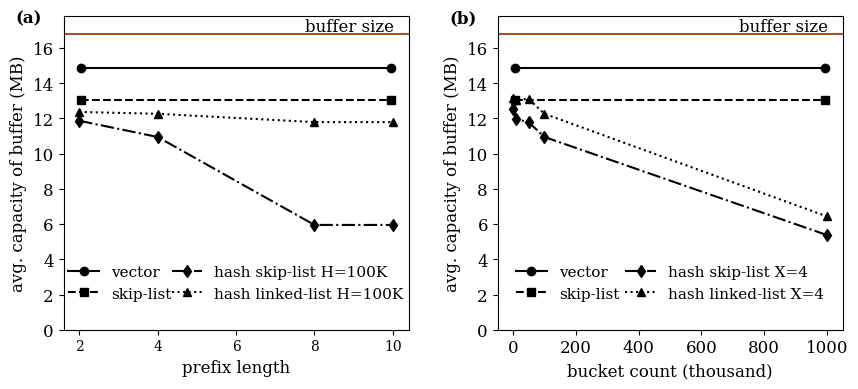

In [106]:
# set the column spacing for the figure  {"hspace": 0.5, "wspace": 0.5}
fig, ax = plt.subplots(1, 2, figsize=(8.7, 4))

buckets = 100000

ax[0].axhline(
    y=16 * 1024 * 1024,
    linestyle="-",
    color="sienna",
)

ax[0].axhline(
    xmin=0.05,
    xmax=0.95,
    y=vec_df["AverageFlushSizeBytes"].values[0],
    label="vector",
    **get_properties("Vector"),
)

ax[0].axhline(
    xmin=0.05,
    xmax=0.95,
    y=skip_df["AverageFlushSizeBytes"].values[0],
    label="skip-list",
    **get_properties("Skiplist"),
)

hash_skipdf.sort_values("prefixlen", inplace=True)
tempdf = hash_skipdf[hash_skipdf["bucket_count"] == buckets]

ax[0].plot(
    tempdf["prefixlen"],
    tempdf["AverageFlushSizeBytes"],
    label=f"hash skip-list H={buckets//(1000)}K",
    **get_properties("Hashskiplist"),
)

hash_linkdf.sort_values("prefixlen", inplace=True)
tempdf = hash_linkdf[hash_linkdf["bucket_count"] == buckets]

ax[0].plot(
    tempdf["prefixlen"],
    tempdf["AverageFlushSizeBytes"],
    label=f"hash linked-list H={buckets//(1000)}K",
    **get_properties("Hashlinklist"),
)
ax[0].set_xlabel("prefix length", fontsize=12)
ax[0].set_ylabel("avg. capacity of buffer (MB)", fontsize=12)

ax[0].text(x=-0.14, y=0.98, s='(a)', fontsize=12,
    horizontalalignment='left', 
    transform=ax[0].transAxes, fontweight='bold')

ax[0].text(x=0.7, y=0.95, s='buffer size', fontsize=12,
    horizontalalignment='left', 
    transform=ax[0].transAxes)


ax[0].set_ylim(bottom=0, top=17 * 1024 * 1024)
ax[0].set_yticklabels([f"{int(i/(1000*1000))}" for i in ax[0].get_yticks()], fontsize=12)
ax[0].legend(loc="upper center", fontsize=11, ncol=2, bbox_to_anchor=(0.5, 0.25), frameon=False, columnspacing=0.01)


prefix_len = 4

ax[1].axhline(
    y=16 * 1024 * 1024,
    linestyle="-",
    color="sienna",
)

ax[1].axhline(
    xmin=0.05,
    xmax=0.95,
    y=vec_df["AverageFlushSizeBytes"].values[0],
    label="vector",
    **get_properties("Vector"),
)

ax[1].axhline(
    xmin=0.05,
    xmax=0.95,
    y=skip_df["AverageFlushSizeBytes"].values[0],
    label="skip-list",
    **get_properties("Skiplist"),
)

hash_skipdf.sort_values("bucket_count", inplace=True)
tempdf = hash_skipdf[(hash_skipdf["prefixlen"] == prefix_len)]

ax[1].plot(
    tempdf["bucket_count"],
    tempdf["AverageFlushSizeBytes"],
    label=f"hash skip-list X={prefix_len}",
    **get_properties("Hashskiplist"),
)

hash_linkdf.sort_values("bucket_count", inplace=True)
tempdf = hash_linkdf[(hash_linkdf["prefixlen"] == prefix_len)]

ax[1].plot(
    tempdf["bucket_count"],
    tempdf["AverageFlushSizeBytes"],
    label=f"hash linked-list X={prefix_len}",
    **get_properties("Hashlinklist"),
)
ax[1].set_xlabel("bucket count (thousand)", fontsize=12)
ax[1].set_ylabel("avg. capacity of buffer (MB)", fontsize=12)

ax[1].text(x=-0.14, y=0.98, s='(b)', fontsize=12,
    horizontalalignment='left', 
    transform=ax[1].transAxes, fontweight='bold')

ax[1].text(x=0.7, y=0.95, s='buffer size', fontsize=12,
    horizontalalignment='left', 
    transform=ax[1].transAxes)


ax[1].set_ylim(bottom=0, top=17 * 1024 * 1024)
ax[1].set_yticklabels([f"{int(i/(1000*1000))}" for i in ax[1].get_yticks()], fontsize=12)

ax[1].set_xticklabels([f"{int(i/(1000))}" for i in ax[1].get_xticks()], fontsize=12)

ax[1].legend(loc="upper center", fontsize=11, ncol=2, bbox_to_anchor=(0.5, 0.25), frameon=False, columnspacing=0.4)

plt.tight_layout()

plt.savefig("buffer-size.eps", format="eps", bbox_inches="tight", dpi=1200)
